# Cavern storage capacity

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar

from src import capacity as cap
from src import functions as fns
from src import data as rd

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.read_dat_file(dat_path=os.path.join("data", "kish-basin"))

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

### Exploration wells

In [5]:
# 500 m buffer - suggested in draft OREDP II p. 108
wells, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

### Wind farms

In [6]:
# the shapes are used as is without a buffer - suggested for renewable energy
# test site areas in draft OREDP II p. 109
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

### Frequent shipping routes

In [7]:
# 1 NM (1,852 m) buffer - suggested in draft OREDP II p. 108
shipping, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

### Shipwrecks

In [8]:
# Archaeological Exclusion Zones recommendation - 100 m buffer
shipwrecks, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

### Subsea cables

In [9]:
# 750 m buffer - suggested in draft OREDP II p. 109-111
cables, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

### Distance from salt formation edge

In [10]:
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [11]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 85, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

In [12]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 4,336
------------------------------------------------------------
Exclude salt formation edges...
Number of potential caverns: 4,247
Caverns excluded: 2.05%
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1,835
Caverns excluded: 57.68%
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 1,751
Caverns excluded: 59.62%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 1,390
Caverns excluded: 67.94%
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 1,390
Caverns excluded: 67.94%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 1,390
Caverns excluded: 67.94%


In [13]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[85, 155, 311],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

## Capacity

### Volume

In [14]:
caverns["cavern_volume"] = cap.cavern_volume(height=caverns["cavern_height"])
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_volume"]
)

### Mid-point temperature

In [15]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

### Operating pressure

In [16]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepth"])

### Hydrogen gas density

In [17]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

### Working mass of hydrogen

In [18]:
caverns["working_mass"] = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

### Energy storage capacity in GWh

In [19]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Stats

In [20]:
caverns.drop(["x", "y", "TopTWT", "BaseDepth"], axis=1).describe()

,Thickness,TopDepth,cavern_height,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,capacity
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1.390000e+03,1.390000e+03,1390.000000,1390.000000,1.390000e+03,1390.000000
mean,301.271103,1032.944181,151.434532,1112.944181,317868.478887,327.724804,7.619621e+06,2.031899e+07,5.297707,13.125253,2.530383e+06,84.317994
std,82.154311,417.252534,64.388767,417.252534,155027.475670,15.840689,2.947138e+06,7.859035e+06,1.724464,3.990081,1.563884e+06,52.112096
min,175.062400,420.019200,85.000000,500.019200,157915.456354,303.498906,3.290410e+06,8.774426e+06,2.544280,6.575768,6.451587e+05,21.498122
25%,235.347600,695.388100,85.000000,775.388100,157915.456354,314.771476,5.235395e+06,1.396105e+07,3.920218,9.956588,1.477063e+06,49.219019
50%,291.285400,966.166300,155.000000,1046.166300,326452.980096,325.245400,7.147956e+06,1.906122e+07,5.117330,12.796514,2.111148e+06,70.348135
75%,353.398775,1361.360500,155.000000,1441.360500,326452.980096,340.121426,9.939291e+06,2.650478e+07,6.721596,16.462933,3.146511e+06,104.848722
max,754.985800,1917.627900,311.000000,1997.627900,702050.890150,362.018279,1.386832e+07,3.698219e+07,8.684908,20.749774,8.286031e+06,276.108950


In [21]:
# cavern volumes
list(caverns["cavern_volume"].unique())

[702050.8901495441, 326452.98009604175, 157915.45635408553]

In [22]:
# total capacity
caverns[["capacity"]].sum().iloc[0]

117202.01135527749

In [23]:
# total capacity at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

capacity          %
height depth                                 
311    1,000 - 1,500  13822.132077  11.793426
       500 - 1,000     5493.027560   4.686803
       1,500 - 2,000  11542.562184   9.848434
155    1,000 - 1,500  27426.739598  23.401253
       1,500 - 2,000  18755.747453  16.002923
       500 - 1,000    23610.890621  20.145465
85     1,000 - 1,500   4034.140572   3.442040
       1,500 - 2,000   5575.023998   4.756765
       500 - 1,000     6941.747291   5.922891

In [24]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",45283.012248
"1,500 - 2,000",35873.333635
"500 - 1,000",36045.665472


In [25]:
s.groupby("height").sum()[["capacity"]]

,capacity
height,
155,69793.377672
311,30857.721821
85,16550.911862


In [26]:
# number of caverns
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].count()
s["%"] = s["capacity"] / len(caverns) * 100
s

capacity          %
height depth                             
311    1,000 - 1,500        68   4.892086
       500 - 1,000          40   2.877698
       1,500 - 2,000        46   3.309353
155    1,000 - 1,500       288  20.719424
       1,500 - 2,000       155  11.151079
       500 - 1,000         379  27.266187
85     1,000 - 1,500        90   6.474820
       1,500 - 2,000        96   6.906475
       500 - 1,000         228  16.402878

In [27]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",446
"1,500 - 2,000",297
"500 - 1,000",647


In [28]:
s.groupby("height").sum()[["capacity"]]

,capacity
height,
155,822
311,154
85,414


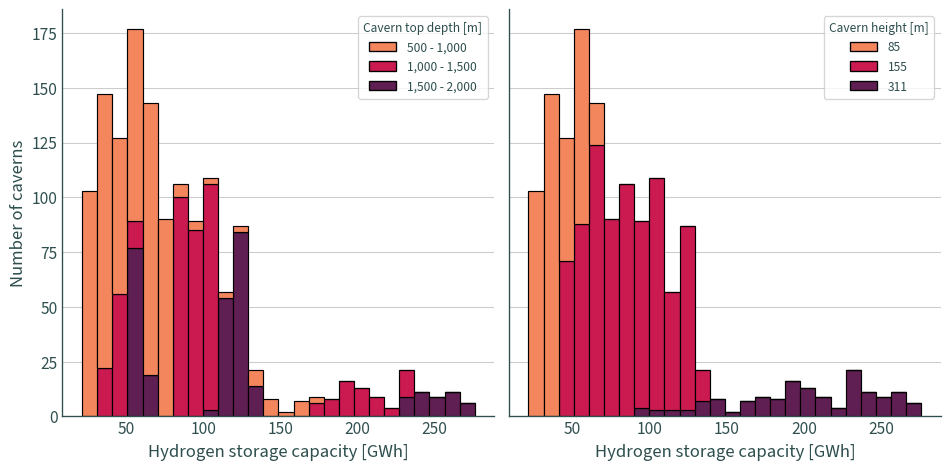

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.histplot(
    caverns.rename(columns={"depth": "Cavern top depth [m]"}).sort_values(
        "TopDepth"
    ),
    x="capacity",
    hue="Cavern top depth [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
    ax=axes[0],
)
sns.histplot(
    caverns.rename(columns={"height": "Cavern height [m]"}).sort_values(
        "Thickness"
    ),
    x="capacity",
    hue="Cavern height [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
    ax=axes[1],
)
axes[0].set_xlabel("Hydrogen storage capacity [GWh]")
axes[1].set_xlabel("Hydrogen storage capacity [GWh]")
axes[0].grid(which="major", axis="y")
axes[1].grid(which="major", axis="y")
axes[0].set_ylabel("Number of caverns")
sns.despine()
plt.tight_layout()
plt.show()

## Maps

In [30]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [31]:
def plot_map_alt(dat_xr, cavern_df, zones_gdf, classes, colours, labels):
    """
    Helper function to plot caverns within the zones of interest
    """

    plt.figure(figsize=(20, 11.5))
    axis = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles = []

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Feasible area",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion area",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    legend_handles.append(
        mpatches.Patch(
            label="Hydrogen storage \ncapacity [GWh]", visible=False
        )
    )

    for x, y, z in zip(classes, colours, labels):
        if x == 0:
            c = cavern_df[cavern_df["capacity"] < x + 40]
        elif x == 160:
            c = cavern_df[cavern_df["capacity"] >= x]
        else:
            c = cavern_df[
                (cavern_df["capacity"] >= x) & (cavern_df["capacity"] < x + 40)
            ]
        for df, markersize in zip(
            [
                c[c["depth"] == "500 - 1,000"],
                c[c["depth"] == "1,000 - 1,500"],
                c[c["depth"] == "1,500 - 2,000"],
            ],
            [20, 50, 20],
        ):
            if len(df) > 0:
                df.centroid.plot(
                    ax=axis,
                    zorder=3,
                    linewidth=0,
                    marker=".",
                    markersize=markersize,
                    color=sns.color_palette("flare", 256)[y],
                )
        legend_handles.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[y], label=z
            )
        )

    legend_handles.append(
        mpatches.Patch(label="Cavern top depth [m]", visible=False)
    )
    for markersize, label in zip(
        [6, 3], ["1,000 - 1,500", "500 - 1,000 or \n1,500 - 2,000"]
    ):
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker=".",
                linewidth=0,
                label=label,
                color="darkslategrey",
                markersize=markersize,
            )
        )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis, crs=rd.CRS, source=cx.providers.CartoDB.VoyagerNoLabels
    )
    axis.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    axis.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles,
        fontsize=11.5,
    )

    plt.tight_layout()
    plt.show()

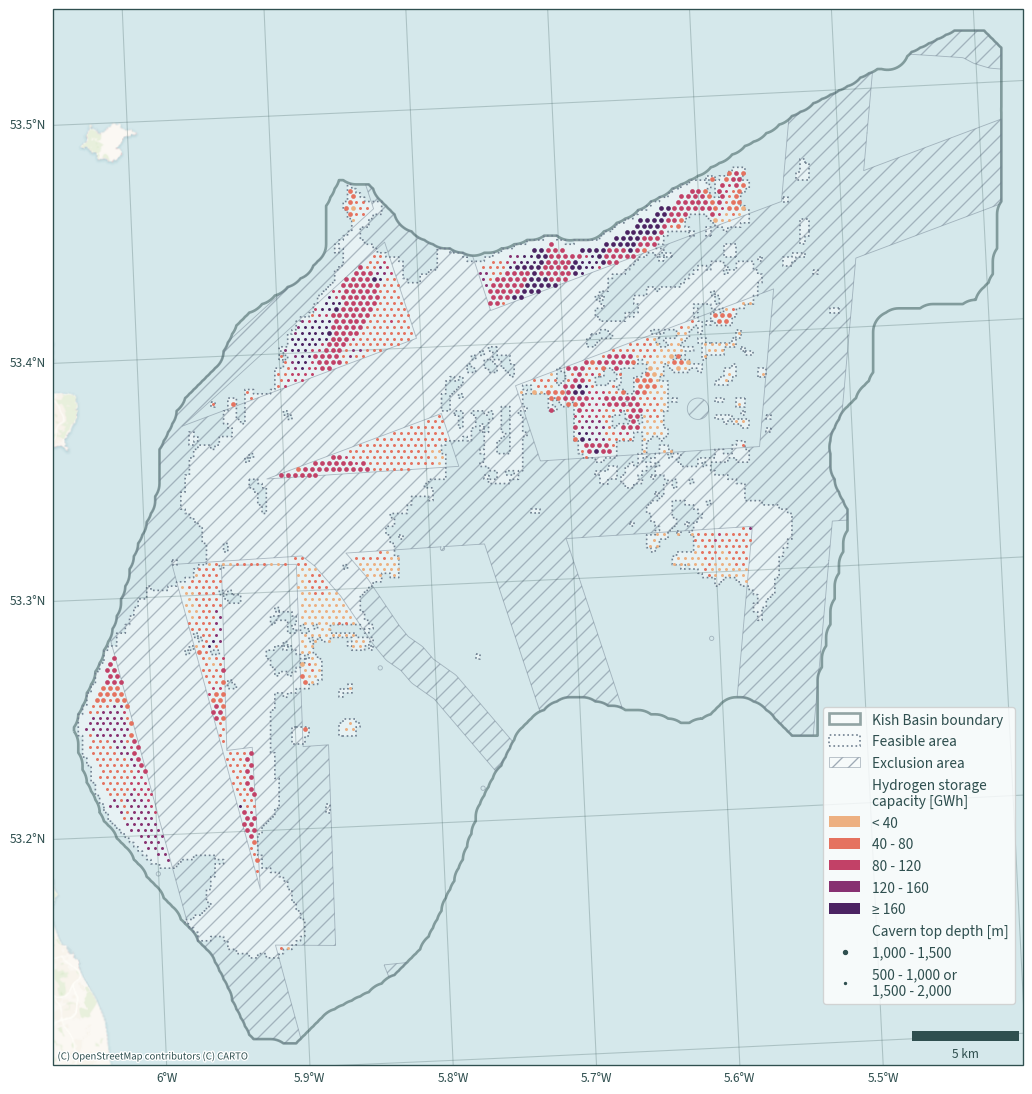

In [32]:
plot_map_alt(
    ds,
    caverns,
    zones,
    [40 * n for n in range(5)],
    [0] + [int(256 / 4) + int(256 / 4) * n - 1 for n in range(4)],
    ["< 40", "40 - 80", "80 - 120", "120 - 160", "≥ 160"],
)

## Restrict cavern height to 155 m

In [35]:
# height = 85 m, 500 m <= depth <= 2,000 m, diameter = 80 m,
# separation = 320 m
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"height": 155, "min_depth": 500, "max_depth": 2000}
)

In [36]:
caverns, caverns_excl = fns.generate_caverns_with_constraints(
    zones_gdf=zones,
    zones_ds=zds,
    dat_extent=extent,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 2,585
------------------------------------------------------------
Exclude salt formation edges...
Number of potential caverns: 2,525
Caverns excluded: 2.32%
------------------------------------------------------------
Exclude frequent shipping routes...
Number of potential caverns: 1,050
Caverns excluded: 59.38%
------------------------------------------------------------
Exclude subsea cables...
Number of potential caverns: 1,031
Caverns excluded: 60.12%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 872
Caverns excluded: 66.27%
------------------------------------------------------------
Exclude exploration wells...
Number of potential caverns: 872
Caverns excluded: 66.27%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 872
Caverns excluded: 66.27%


In [37]:
# label caverns by height and depth
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[155],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [38]:
caverns["cavern_volume"] = cap.cavern_volume(height=caverns["cavern_height"])
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_volume"]
)

caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepth"])

caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

caverns["working_mass"] = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

In [39]:
caverns.drop(["x", "y", "TopTWT", "BaseDepth"], axis=1).describe()

,Thickness,TopDepth,height,cavern_height,cavern_depth,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,capacity
count,872.000000,872.000000,872.0,872.0,872.000000,872.000000,872.000000,8.720000e+02,8.720000e+02,872.000000,872.000000,8.720000e+02,872.000000
mean,344.954012,1052.441725,155.0,155.0,1132.441725,326452.980096,328.522815,7.757336e+06,2.068623e+07,5.385323,13.333493,2.594704e+06,86.461296
std,69.591682,405.399959,0.0,0.0,405.399959,0.000000,15.202498,2.863421e+06,7.635789e+06,1.678441,3.884590,7.204196e+05,24.005983
min,245.000700,420.243700,155.0,155.0,500.243700,326452.980096,304.815389,3.291995e+06,8.778654e+06,2.569225,6.638763,1.328513e+06,44.268991
25%,292.245250,708.436525,155.0,155.0,788.436525,326452.980096,315.622620,5.327559e+06,1.420682e+07,3.971557,10.079783,1.994049e+06,66.446131
50%,336.827850,1033.375550,155.0,155.0,1113.375550,326452.980096,327.807833,7.622668e+06,2.032712e+07,5.407519,13.471401,2.632478e+06,87.720022
75%,380.678425,1362.374925,155.0,155.0,1442.374925,326452.980096,340.145310,9.946457e+06,2.652388e+07,6.724785,16.470469,3.181508e+06,106.014907
max,754.985800,1906.220200,155.0,155.0,1986.220200,326452.980096,360.539507,1.378774e+07,3.676732e+07,8.647580,20.670192,3.924817e+06,130.783640


In [40]:
# cavern volumes
list(caverns["cavern_volume"].unique())

[326452.98009604175]

In [41]:
# total capacity
caverns[["capacity"]].sum().iloc[0]

75394.24986093605

In [42]:
# total capacity at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

capacity          %
height depth                                 
155    1,000 - 1,500  30624.170501  40.618708
       500 - 1,000    23103.382656  30.643428
       1,500 - 2,000  21666.696704  28.737864

In [43]:
# total volume at various depth/height combinations
s = caverns.groupby(["height", "depth"], sort=False)[["cavern_volume"]].sum()
s["%"] = s["cavern_volume"] / caverns[["cavern_volume"]].sum().iloc[0] * 100
s

cavern_volume          %
height depth                                  
155    1,000 - 1,500   1.051179e+08  36.926606
       500 - 1,000     1.204611e+08  42.316514
       1,500 - 2,000   5.908799e+07  20.756881

In [44]:
# number of caverns
s = caverns.groupby(["height", "depth"], sort=False)[["cavern_volume"]].count()
s["%"] = s["cavern_volume"] / len(caverns) * 100
s

cavern_volume          %
height depth                                  
155    1,000 - 1,500            322  36.926606
       500 - 1,000              369  42.316514
       1,500 - 2,000            181  20.756881

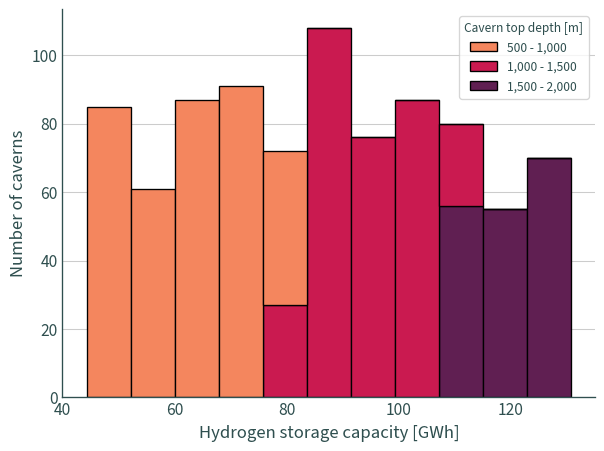

In [47]:
ax = sns.histplot(
    caverns.rename(columns={"depth": "Cavern top depth [m]"}).sort_values(
        "TopDepth"
    ),
    x="capacity",
    hue="Cavern top depth [m]",
    palette="rocket_r",
    multiple="stack",
    alpha=1,
)
ax.set_xlabel("Hydrogen storage capacity [GWh]")
ax.grid(which="major", axis="y")
ax.set_ylabel("Number of caverns")
sns.despine()
plt.tight_layout()
plt.show()

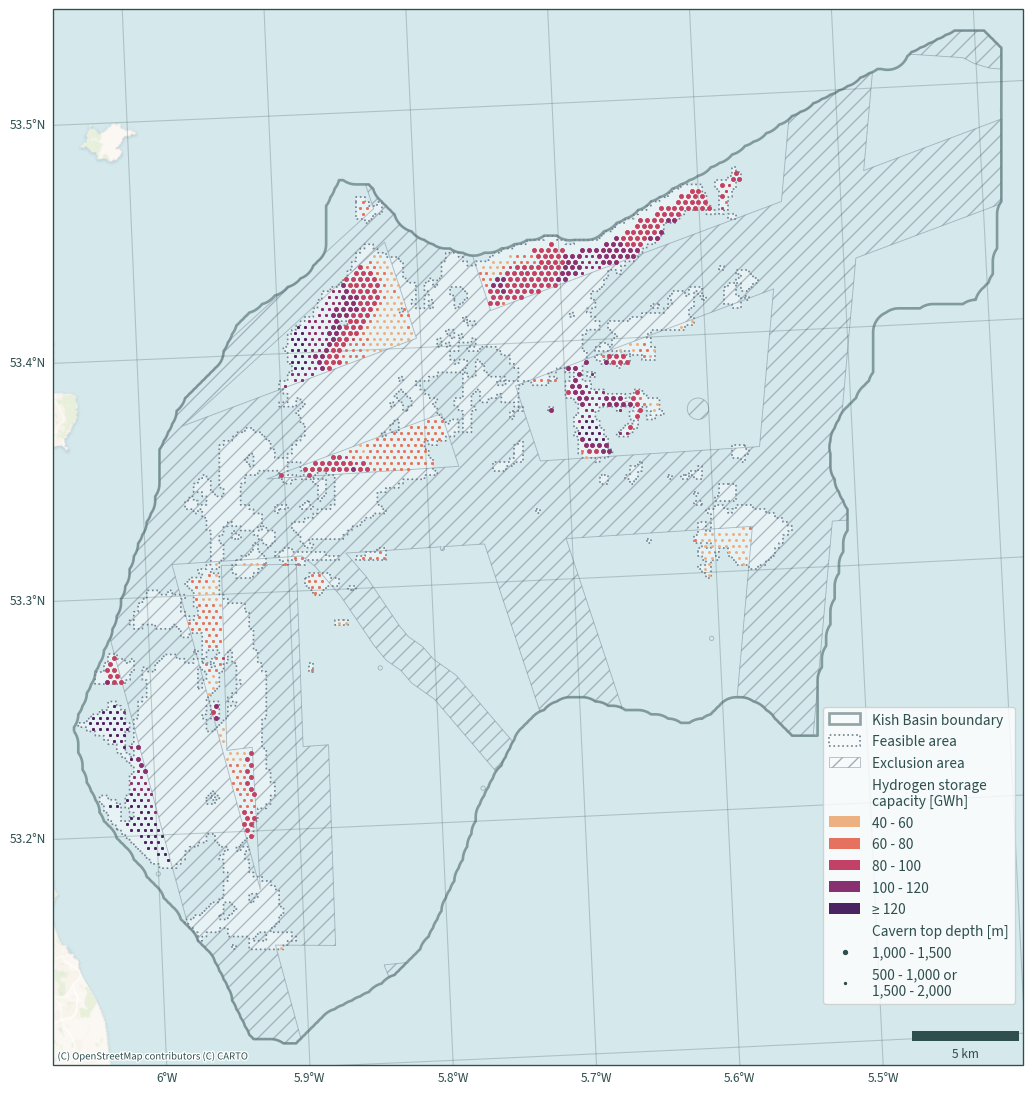

In [57]:
plot_map_alt(
    ds,
    caverns,
    zones,
    [20 + 20 * n for n in range(1, 6)],
    [0] + [int(256 / 4) + int(256 / 4) * n - 1 for n in range(4)],
    ["40 - 60", "60 - 80", "80 - 100", "100 - 120", "≥ 120"],
)